In [2]:
from metadrive.envs.metadrive_env import MetaDriveEnv
from metadrive.manager.traffic_manager import PGTrafficManager
from metadrive.manager.pg_map_manager import PGMapManager
from metadrive.utils.config import Config

# from metadrive.examples.ppo_expert.torch_expert import torch_expert as expert
from metadrive.examples.ppo_expert.numpy_expert import expert
from metadrive.component.map.base_map import BaseMap
from metadrive.component.map.pg_map import MapGenerateMethod
from metadrive.engine.logger import get_logger, set_log_level

import logging
import mediapy
from utils.scenario_runner import ScenarioRunner
from pathlib import Path
import numpy as np

log = get_logger()

In [3]:
def get_default_config(seed=0, dt=0.02, dr=1) -> dict:

    # ===== Termination Scheme =====
    termination_sceme = dict(
        out_of_route_done=False,
        on_continuous_line_done=False,
        crash_vehicle_done=False,
        crash_object_done=False,
        crash_human_done=False,
    )
    # ===== Map Config =====
    map_config = {
        BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_NUM,
        BaseMap.GENERATE_CONFIG: 3,  # 20 block
    }

    return dict(
        # use_render=True,
        log_level=logging.INFO,  # logging.DEBUG
        traffic_density=0.01,
        traffic_mode="respawn",
        random_traffic=False,
        map_config=map_config,
        **termination_sceme,
        decision_repeat=dr,
        physics_world_step_size=dt,
        start_seed=seed,
    )

In [4]:
env = MetaDriveEnv(config=get_default_config(dt=1 / 50))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


In [5]:
_, reset_info = env.reset()

[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


In [6]:
env_dt, env_dr = env.config["physics_world_step_size"], env.config["decision_repeat"]
WORLD_FPS = 1 / (env_dt * env_dr)
log.info(f"World FPS: {WORLD_FPS}")

[INFO] World FPS: 50.0


In [7]:
action = expert(env.agent, deterministic=True)
obs, reward, terminated, truncated, info = env.step(action)

[INFO] Torch is not available. Use numpy PPO expert.


In [8]:
env.engine.traffic_manager.get_objects()

{'b39a6534-7a0f-4723-a76b-da3a071965e8': DefaultVehicle, ID:b39a6534-7a0f-4723-a76b-da3a071965e8,
 '85060573-fa54-4256-9b47-4201be1649c1': MVehicle, ID:85060573-fa54-4256-9b47-4201be1649c1,
 'c696cfae-d50c-4042-bfa3-7df444dff7be': LVehicle, ID:c696cfae-d50c-4042-bfa3-7df444dff7be,
 'df0d6442-bd06-432b-879c-52ad70a02be9': MVehicle, ID:df0d6442-bd06-432b-879c-52ad70a02be9}

In [9]:
RENDER_SCALING = 3


def screen_size() -> tuple:
    b_box = env.current_map.road_network.get_bounding_box()
    x_len, y_len = b_box[1] - b_box[0], b_box[3] - b_box[2]
    width = int(x_len * RENDER_SCALING * 1.05)
    height = int(y_len * RENDER_SCALING * 1.05)
    return width, height


screen_size()

(416, 1169)

In [10]:
vehicles = env.agent_manager.get_objects()
# Get state of each vehicle except the agent
state = {k: v.get_state() for k, v in vehicles.items() if k != env.agent.id}

In [11]:
state

{'85060573-fa54-4256-9b47-4201be1649c1': {'position': [20.0,
   7.0,
   0.6850000023841858],
  'heading_theta': 0.0,
  'roll': np.float64(0.0),
  'pitch': np.float64(0.0),
  'velocity': array([0., 0.]),
  'type': metadrive.component.vehicle.vehicle_type.MVehicle,
  'steering': 0.0,
  'throttle_brake': np.float64(1.0),
  'crash_vehicle': False,
  'crash_object': False,
  'crash_building': False,
  'crash_sidewalk': False,
  'size': (4.6, 1.85, 1.37),
  'length': 4.6,
  'width': 1.85,
  'height': 1.37,
  'spawn_road': ('>>', '>>>'),
  'destination': ('3C0_0_', '3C0_1_')},
 'c696cfae-d50c-4042-bfa3-7df444dff7be': {'position': [20.0,
   3.5,
   0.925000011920929],
  'heading_theta': 0.0,
  'roll': np.float64(0.0),
  'pitch': np.float64(0.0),
  'velocity': array([0., 0.]),
  'type': metadrive.component.vehicle.vehicle_type.LVehicle,
  'steering': 0.0,
  'throttle_brake': np.float64(1.0),
  'crash_vehicle': False,
  'crash_object': False,
  'crash_building': False,
  'crash_sidewalk': False,

In [30]:
_.shape

(1169, 416, 3)

In [8]:
def get_frame(env):
    b_box = env.current_map.road_network.get_bounding_box()
    x_len, y_len = b_box[1] - b_box[0], b_box[3] - b_box[2]

    scaling = 3
    return env.render(
        mode="topdown",
        window=False,
        screen_size=(x_len * scaling * 1.05, y_len * scaling * 1.05),
        camera_position=env.current_map.get_center_point(),
        scaling=scaling,
        draw_contour=True,
        draw_target_vehicle_trajectory=True,
        semantic_map=False,
        num_stack=1,
    )

""

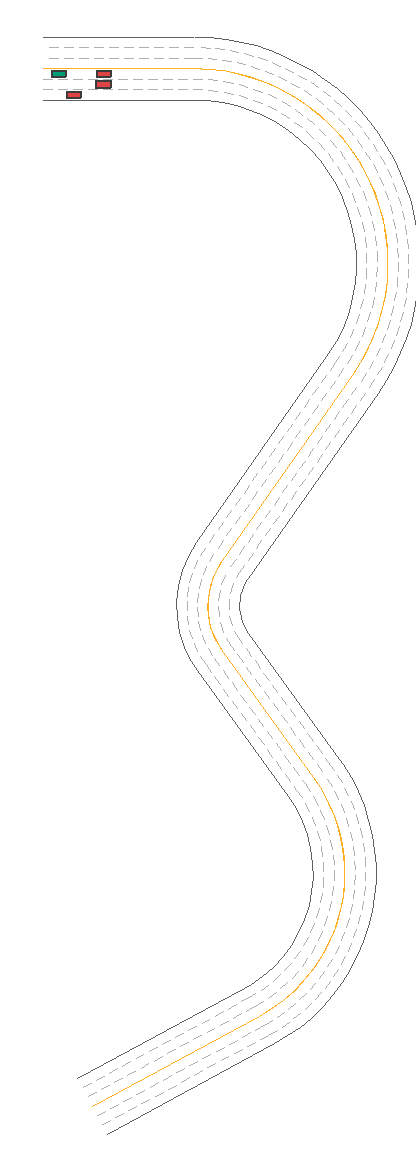

In [9]:
mediapy.show_image(get_frame(env))
env.close()

In [10]:
def get_max_steps(env: MetaDriveEnv, fps: int) -> int:
    """
    Return maximum number of simulation steps.

    Assume minimal target velocity e.g. 2m/s.
    Dependant on the total route length.
    Adaptable to fidelity parameters.
    """

    distance = env.agent.navigation.total_length
    V_min = 2.0  # [m/s]  # set minimal velocity to 2m/s
    max_time = distance / V_min  # [s] maximum time allowed to reach the destination
    max_steps = round(max_time * fps)  # maximum number of simulation steps frames

    log.info(f"Calculating max steps with: ")
    log.info(f"{V_min = }, {distance = }, {max_time = }, {fps = } {max_steps = }")

    return max_steps

In [11]:
import time

WORLD_FPS = 60
RECORD_VIDEO_FPS = 10


def run_scenario(ads_fps=10, seed=0):
    env = MetaDriveEnv(config=get_default_config(seed, dt=1 / WORLD_FPS))
    env.reset()
    assert WORLD_FPS % ads_fps == 0, "ADS FPS must be a multiple of worlds FPS"
    assert env.config["decision_repeat"] == 1, "Decision repeat must be 1"
    skip_rate = WORLD_FPS // ads_fps
    log.info(f"World FPS: {WORLD_FPS}, ADS FPS: {ads_fps}, Ratio: {skip_rate}")

    frames = []
    timings = {"agent": 0}
    scenario_start = time.perf_counter()

    for step_no in range(get_max_steps(env, WORLD_FPS)):
        log.debug(f"Step {step_no}")
        if step_no % skip_rate == 0:
            log.debug(f"Getting agent's action")
            agent_start = time.perf_counter()
            action = expert(env.agent, deterministic=True)
            timings["agent"] += time.perf_counter() - agent_start

        obs, reward, terminated, truncated, info = env.step(action)

        if step_no % (WORLD_FPS // RECORD_VIDEO_FPS) == 0:
            frames.append(get_frame(env))

        if terminated or truncated:
            break
    timings["scenario"] = time.perf_counter() - scenario_start

    env.close()
    return frames, timings

In [12]:
clips = []
timings = {}

for fps in [10, 20, 30, 60]:
    scenario_frames, scenario_timings = run_scenario(fps)
    clips.append(scenario_frames)
    timings[f"{fps} FPS"] = scenario_timings

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] World FPS: 60, ADS FPS: 10, Ratio: 6
[INFO] Calculating max steps with: 
[INFO] V_min = 2.0, distance = np.float64(502.4061088704075), max_time = np.float64(251.20305443520374), fps = 60 max_steps = 15072
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] World FPS: 60, ADS FPS: 20, Ratio: 3
[INFO] Calculating max steps with: 
[INF

In [13]:
mediapy.set_show_save_dir("data")

mediapy.show_videos(clips, titles=list(timings.keys()), fps=10)

In [14]:
timings

{'10 FPS': {'agent': 1.867967647029218, 'scenario': 9.643709343999944},
 '20 FPS': {'agent': 3.620330703979562, 'scenario': 11.222289844001352},
 '30 FPS': {'agent': 5.502314920033314, 'scenario': 13.29003017300056},
 '60 FPS': {'agent': 10.831082493948998, 'scenario': 18.647618781000347}}

NameError: name 'env' is not defined